In [1]:
import os
import requests
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
import time
import os.path
from os import path

import sys
sys.path.insert(0, '../completenessContours')
import compute_num_completeness_w_ve_insol as kp

sys.path.insert(0, '..')
import occRateModels as rm
import occRateUtils as ut

In [2]:
stellarCatalog = "../stellarCatalogs/dr25_stellar_berger2019_clean_GK.txt"
pcCatalog = "../GKbaseline/koiCatalogs/dr25_GK_PCs.csv"

innerHZ = kp.earthflux_at_semia(1, 4.437, 5778.0, 0.75)
outerHZ = kp.earthflux_at_semia(1, 4.437, 5778.0, 1.77)
print("HZ flux: " + str(innerHZ) + " to " + str(outerHZ))

pessimisticInnerHz = 1.1;
pessimisticOuterHz = 0.25;

optimisticInnerHz = 1.8;
optimisticOuterHz = 0.25;

cs = ut.compSpace(periodName = "Insolation", 
               periodUnits = "Earth Flux",
               periodRange = (0.2, 2.0), 
               nPeriod = 61, 
               radiusName = "Radius", 
               radiusUnits = "$R_\oplus$",
               rpRange = (0.75, 2.5), 
               nRp = 61)

# for quick tests
# nWalkers = 6
# nBurnin = 200
# nMcmc = 1000
# for production runs
nWalkers = 16
nBurnin = 1000
nMcmc = 5000

# model = rm.dualPowerLaw()
model = rm.gaussiansxPowerLaw()
whichRadii = "corrected"

case = "_extrap_const"
# case = "_extrap_zero"

# make output directory if needed
outDir = "occ_" + model.name + case + "_out"
if not path.exists(outDir):
    os.mkdir(outDir)


HZ flux: 1.7777777777777777 to 0.3191930798940279


In [3]:
def getRadii(catalog):
    if whichRadii == "corrected":
        return catalog.corrected_prad
    if whichRadii == "corrected Minus 1Sigma":
        return catalog.corrected_prad - catalog.corrected_prad_err1
    elif whichRadii == "kic":
        return catalog.koi_prad
    else:
        raise ValueError('Bad whichRadii string');

In [5]:
stellarTargets = pd.read_csv(stellarCatalog)

base_kois = pd.read_csv(pcCatalog)
base_kois = pd.merge(base_kois, stellarTargets[["kepid","logg"]], left_on="kepid_x", right_on="kepid", how="inner")

base_kois["insolation"] = kp.earthflux_at_period(base_kois.radius, base_kois.logg, base_kois.teff, base_kois.koi_period)

# m = (cs.periodRange[0] <= base_kois.insolation) & (base_kois.insolation <= cs.periodRange[1])
# thisRadii = getRadii(base_kois)
# m &= np.isfinite(thisRadii) & (cs.rpRange[0] <= thisRadii) & (thisRadii <= cs.rpRange[1])
    
# kois = pd.DataFrame(base_kois[m])
# allKois = kois
allKois = base_kois


In [6]:
travisData = pd.read_csv("../data/GKSPCIIPapTable1_2020-05-28.csv")

In [7]:
travisData

,KIC,KOI,koi_disposition,gaia_iso_prad,gaia_iso_prad_errp,gaia_iso_prad_errm,gaia_iso_sma,gaia_iso_sma_errp,gaia_iso_sma_errm,gaia_iso_insol,gaia_iso_insol_errp,gaia_iso_insol_errm,ZAMSFlux,Flag
0,11446443,1.01,CONFIRMED,14.212560,0.294843,0.285477,0.035501,0.000846,0.000827,854.783579,69.343423,64.808067,524.748828,AO
1,10666592,2.01,CONFIRMED,16.450507,0.349882,0.340694,0.038072,0.000530,0.000595,4285.953679,331.232094,336.993397,2394.683701,AO
2,10748390,3.01,CONFIRMED,4.882821,0.075502,0.073153,0.051553,0.000590,0.000355,86.579152,5.241528,4.725902,58.223102,NaN
3,3861595,4.01,CONFIRMED,13.184877,0.421749,0.823027,0.058263,0.000693,0.001514,5244.420044,478.898053,520.464806,3647.632344,AO
4,11853905,7.01,CONFIRMED,4.013147,0.097726,0.100405,0.045494,0.000737,0.001032,1247.169290,99.090802,99.018185,719.802835,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3893,8329346,8275.01,CANDIDATE,4.062407,0.233536,0.521989,0.995925,0.019914,0.022566,0.553998,0.076271,0.066608,0.412692,HZ
3894,8637903,8276.01,CANDIDATE,3.480798,0.106291,0.531763,1.125958,0.011173,0.012914,2.289274,0.184150,0.186231,1.862489,Young
3895,9011955,8279.01,CANDIDATE,55.223564,13712.719833,679.167128,1.060196,0.033271,0.027538,2.963890,0.465681,0.396620,1.324871,NaN
3896,9159288,8280.01,CANDIDATE,3.005948,0.101021,0.376791,0.345798,0.005862,0.006570,22.924142,2.285114,2.241219,16.129029,NaN


In [8]:
allKois

,kepid_x,kepoi_name,koi_tce_plnt_num,koi_pdisposition,koi_score,koi_period,koi_max_mult_ev,koi_prad,koi_prad_err1,koi_prad_err2,...,fpp_koi_period,fpp_prob,fpEffectiveness,obsFpRate,reliability,fpp_prob_use,totalReliability,kepid,logg,insolation
0,10854555,K00755.01,1,CANDIDATE,1.000,2.525592,33.191900,2.75,0.88,-0.35,...,2.526,0.001000,0.997936,2.019542e-04,1.000000,0.001000,0.999000,10854555,4.486280,609.323390
1,10872983,K00756.01,1,CANDIDATE,1.000,11.094321,55.204865,3.90,1.27,-0.42,...,11.094,0.000036,0.997936,1.556823e-06,1.000000,0.000036,0.999964,10872983,4.349270,135.677944
2,10872983,K00756.02,2,CANDIDATE,1.000,4.134435,33.546658,2.77,0.90,-0.30,...,4.134,0.000006,0.997936,1.933760e-04,1.000000,0.000006,0.999993,10872983,4.349270,505.927894
3,10872983,K00756.03,3,CANDIDATE,0.992,2.566589,12.325094,1.59,0.52,-0.17,...,2.567,0.000078,0.996951,2.409895e-02,0.999924,0.000078,0.999846,10872983,4.349270,955.363038
4,5456651,K00835.01,1,CANDIDATE,1.000,11.763072,39.560696,2.35,0.17,-0.08,...,11.763,0.000040,0.997936,5.804996e-05,1.000000,0.000040,0.999960,5456651,4.570179,35.377502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1889,9002278,K00701.02,2,CANDIDATE,1.000,5.714897,57.161266,1.33,0.08,-0.06,...,5.715,0.000047,0.997936,8.729110e-07,1.000000,0.000047,0.999953,9002278,4.599499,85.333045
1890,9002278,K00701.03,3,CANDIDATE,0.994,122.385868,35.940640,1.72,0.10,-0.07,...,122.386,0.002800,0.997936,1.855118e-03,0.999996,0.002800,0.997196,9002278,4.599499,1.434895
1891,9002278,K00701.05,5,CANDIDATE,0.989,12.441800,8.523661,0.57,0.04,-0.02,...,12.442,0.014000,0.962050,6.967660e-02,0.997046,0.014000,0.983087,9002278,4.599499,30.242485
1892,9266431,K00704.01,1,CANDIDATE,1.000,18.396297,57.642532,2.47,0.23,-0.12,...,18.396,0.002500,0.997936,1.056572e-06,1.000000,0.002500,0.997500,9266431,4.577024,24.641133


In [9]:
for i in range(len(travisData)):
    travisData.loc[i, "kepoi_name"] = "K%08.2f"%travisData.loc[i].KOI

In [10]:
travisData

,KIC,KOI,koi_disposition,gaia_iso_prad,gaia_iso_prad_errp,gaia_iso_prad_errm,gaia_iso_sma,gaia_iso_sma_errp,gaia_iso_sma_errm,gaia_iso_insol,gaia_iso_insol_errp,gaia_iso_insol_errm,ZAMSFlux,Flag,kepoi_name
0,11446443,1.01,CONFIRMED,14.212560,0.294843,0.285477,0.035501,0.000846,0.000827,854.783579,69.343423,64.808067,524.748828,AO,K00001.01
1,10666592,2.01,CONFIRMED,16.450507,0.349882,0.340694,0.038072,0.000530,0.000595,4285.953679,331.232094,336.993397,2394.683701,AO,K00002.01
2,10748390,3.01,CONFIRMED,4.882821,0.075502,0.073153,0.051553,0.000590,0.000355,86.579152,5.241528,4.725902,58.223102,NaN,K00003.01
3,3861595,4.01,CONFIRMED,13.184877,0.421749,0.823027,0.058263,0.000693,0.001514,5244.420044,478.898053,520.464806,3647.632344,AO,K00004.01
4,11853905,7.01,CONFIRMED,4.013147,0.097726,0.100405,0.045494,0.000737,0.001032,1247.169290,99.090802,99.018185,719.802835,NaN,K00007.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3893,8329346,8275.01,CANDIDATE,4.062407,0.233536,0.521989,0.995925,0.019914,0.022566,0.553998,0.076271,0.066608,0.412692,HZ,K08275.01
3894,8637903,8276.01,CANDIDATE,3.480798,0.106291,0.531763,1.125958,0.011173,0.012914,2.289274,0.184150,0.186231,1.862489,Young,K08276.01
3895,9011955,8279.01,CANDIDATE,55.223564,13712.719833,679.167128,1.060196,0.033271,0.027538,2.963890,0.465681,0.396620,1.324871,NaN,K08279.01
3896,9159288,8280.01,CANDIDATE,3.005948,0.101021,0.376791,0.345798,0.005862,0.006570,22.924142,2.285114,2.241219,16.129029,NaN,K08280.01


In [11]:
allKois = pd.merge(allKois, travisData, on="kepoi_name", how="inner")


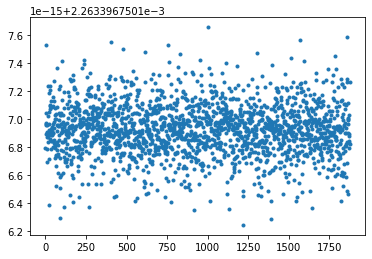

In [12]:
plt.plot((allKois.corrected_prad - allKois.gaia_iso_prad)/allKois.corrected_prad, '.')

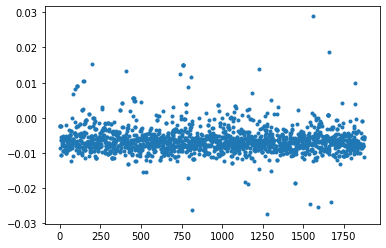

In [13]:
plt.plot((allKois.insolation - allKois.gaia_iso_insol)/allKois.insolation, '.')

In [17]:
np.mean((allKois.corrected_prad - allKois.gaia_iso_prad)/allKois.corrected_prad)

0.0022633967500669265

In [18]:
np.std((allKois.corrected_prad - allKois.gaia_iso_prad)/allKois.corrected_prad)

1.8642065304812123e-16

In [16]:
np.mean((allKois.insolation - allKois.gaia_iso_insol)/allKois.insolation)

-0.006430120960926095

In [19]:
np.std((allKois.insolation - allKois.gaia_iso_insol)/allKois.insolation)

0.0037307928470110656